# issues need to be resolved



# 1 Learning objectives
* Understand the basis of deep learning 
* Learn how to train a detection model
* Evaluate model performce
* Improve model training
* Tune a model with new datasets

# 2 Introduction to deep learning for object detection
##  2.1 What is deep learning?

### Introduction to deep learning
The term ‘Artificial Intelligence (AI)’ has been introduced for 50 years and still it is in the global trend. These days machine learning (ML) is interchangeably used for AI as it is one of the most popular and successful sub-branches of AI. Deep learning is a subset of ML that uses multi-layered neural networks, to mimic human like decision making behavior and try to find the most optimal path to a solution

### Deep learning for image recognition
Deep Learning has been exceptionally powerful when it comes to image recognition. Using the neural networks with multiple layers (deep neural networks), these models can automatically learn features and pattern directly from raw image data, significantly outperforming traditional image processing methods.
## 2.2 Benefits
### Application in practice

Deep learning for object detection has a wide range of practical applications, including:
* **Automated Surveillance:** Enhancing security systems by accurately detecting and classifying objects in real-time.
* **Autonomous Vehicles:** Enabling self-driving cars to recognize and respond to various objects on the road.
* **Medical Imaging:** Assisting in the detection of anomalies in medical scans, improving diagnostic accuracy.
* **Industrial Automation:** Streamlining manufacturing processes by identifying and categorizing different components.
* **Remote Sensing (RS) and Earth Observation (EO):** Deep learning models can analyze satellite and aerial imagery with high precision, improving environmental monitoring and disaster response. For example, they can detect deforestation, urban expansion, and climate change impacts, as well as rapidly identify areas affected by natural disasters such as floods, hurricanes, and wildfires. This facilitates timely decision-making and efficient resource allocatio.


## 2.3 Overview of developing a detection model
Developing a deep leaning model for object detection involves several key steps:
*  **Dataset Preparation:** Collecting and annotating images relevant to the detection task.
*  **Model Selection:** Choosing an appropriate deep learning architecture, such as Faster R-CNN, YOLO.
*  **Training:** Feeding the annotated dataset into the model and adjusting parameters to optimize performance.
*  **Evaluation:** Assessing the model's accuracy using metrics like Mean Average Precision (mAP).
*  **Tuning:** Refining the model through hyperparameter tuning, data augmentation, and other techniques to improve detection accuracy and robustness.


# 3 Prerequisites

### 3.1 Preferred skillsets for the following hands-on practice
#### Recommended pre-reading materials
* MMDetection Documentation
* MMDetection Benchmark and Model Zoo

### 3.2 System requirements
#### Hardware recommendation
* Processor: A modern multi-core processor, such as an Intel Core i7 (8th generation or newer) or an AMD Ryzen 7 (3rd generation or newer)
* RAM: 16 GiB
* GPU: NVIDIA GeForce GTX 1070 Ti or a more powerful GPU with at least 8 GiB of VRAM
* NVIDIA-SMI Version: 510 or later

#### Software Installation
* [Anaconda/ Miniconda](https://docs.anaconda.com/miniconda/miniconda-install/)
* [Install JupyterLab](https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html)
* [Install git](https://git-scm.com/book/en/v2/Getting-Started-Installing-Git)

This notebook demonstrates the steps to finetune a model for crane detection. We start by setting up the environment, preparing the dataset, and then proceed to train and evaluate the model. Working with the proper versions of packages and libraries is essential. The environment can be set up with the following codes. First, we create the environment `craneDetection` where all required packages will be installed.

#### Installing Required Packages
First, ensure that you have Miniconda installed. Then, create a new Conda environment and install the necessary libraries:


```bash
# Create a new conda environment
conda create -n craneDetection python=3.10

# Activate the newly created environment
conda activate craneDetection

# Install PyTorch and CUDA
conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia

# Install MMDetection dependencies
pip install -U openmim
mim install mmengine
mim install mmdet==3.3.0
mim install mmcv==2.1.0

# Install additional packages
pip install labelme
pip install -U labelme2coco

# Clone the mmdetection repository and install it
conda install anaconda::git
git clone https://github.com/open-mmlab/mmdetection
cd mmdetection
pip install -e . .

# Install ipykernel
conda install anaconda::ipykernel
python -m ipykernel install --user --name craneDetection --display-name "Crane Detection"

# 4 Preparation of training dataset
###  Formats for training datasets

### Labeling
Labeling Process for Crane Detection in Ship Harbors

1.	Locating Harbor Scenes:
    * Search for the harbor location in Google Earth with the extent.
	* Set the eye altitude at 900m and cover the harbor location
	* Export the scene in, including the harbor, as an image file. The guide for exporting the scene from Google Earth is well documented [here](https://glodal.sharepoint.com/sites/GLODAL/_layouts/15/Doc.aspx?sourcedoc=%7Bd4a5c3d5-c2c1-4a88-ac92-93322d905443%7D&action=default&wdLOR=cE0A42B43%2D8477%2D4089%2D9692%2DBBEC9D6AEE90&slrid=ec433ba1-c0cf-3000-840d-d041b7425767&originalPath=aHR0cHM6Ly9nbG9kYWwuc2hhcmVwb2ludC5jb20vOnc6L3MvR0xPREFML0VkWERwZFRCd29oS3JKS1RNaTJRVkVNQk0yUXZQckx3eUg4ZUk2bWNETTJvd2c_cnRpbWU9WVZwczFiQ2gzRWc&CID=924ce444-671d-4815-89a5-1a011eb94f9f&_SRM=0:G:255).
2.	Annotating Cranes:
	* Open the exported image in the ‘labelme’ tool.
	* Use the ‘Create Polygons’ feature to draw the borders around the cranes in the image.
	* Once the crane annotation is complete, label the polygon as “crane”.
	* Save the annotation, which will be stored in JSON format in the same folder as the image.
3.	Converting Annotations to COCO Format:
	* Use the labelme2coco package to convert the JSON annotations from labelme to the COCO format.
	* Apply the convert method provided by the labelme2coco to perform the conversion.
	
This process ensures that the annotations are correctly labeled and converted to a standard coco data format for further analysis in crane detection tasks.


### Data Split

The dataset is split using a randomized approach. The paths of all image files are collected and shuffled to ensure randomness. The dataset is then divided into 70% for the training set and 30% for the validation set, ensuring that the training and validation sets are randomly selected and non-overlapping. Once the images are annotated using Labelme, the data folder will contain .tif image files along with .json files consisting of annotations. The script takes all the images from the ./data folder, splits the data into a 70:30 ratio between train and test sets, and places these sets inside the data_converted_to_coco folder, maintaining the original pairing between image files (.tif) and their corresponding annotation files (.json).

In [1]:
import os
import glob
import random
import math
import shutil

orig_path = "./data"
to_path = "./data_converted_to_coco"
os.makedirs(os.path.join(to_path, "train"), exist_ok=True)
os.makedirs(os.path.join(to_path, "test"), exist_ok=True)

path_ = glob.glob(os.path.join(orig_path, "*.tif"))

random.shuffle(path_)
split_index = math.ceil(len(path_) * 0.7)

list_A = path_[:split_index]
list_B = path_[split_index:]

for x in list_A:
    img_path = x
    json_path = x.replace(".tif", ".json")

    shutil.copy(img_path, os.path.join(to_path, "train", os.path.basename(img_path)))
    shutil.copy(json_path, os.path.join(to_path, "train", os.path.basename(json_path)))

for x in list_B:
    img_path = x
    json_path = x.replace(".tif", ".json")

    shutil.copy(img_path, os.path.join(to_path, "test", os.path.basename(img_path)))
    shutil.copy(json_path, os.path.join(to_path, "test", os.path.basename(json_path)))


Now we convert the splitted data to COCO format using labelme2coco as:

In [2]:
import labelme2coco

labelme2coco.convert('./data_converted_to_coco/train','./data_converted_to_coco/train.json/')
labelme2coco.convert('./data_converted_to_coco/test','./data_converted_to_coco/test.json/')

07/24/2024 12:11:09 - INFO - numexpr.utils -   NumExpr defaulting to 8 threads.


There are 68 listed files in folder train.


Converting labelme annotations to COCO format: 100%|██████████| 68/68 [00:00<00:00, 758.86it/s]
07/24/2024 12:11:21 - INFO - labelme2coco -   Converted annotations in COCO format is exported to data_converted_to_coco/train.json/dataset.json


There are 28 listed files in folder test.


Converting labelme annotations to COCO format: 100%|██████████| 28/28 [00:00<00:00, 650.64it/s]
07/24/2024 12:11:21 - INFO - labelme2coco -   Converted annotations in COCO format is exported to data_converted_to_coco/test.json/dataset.json


# 5 Experiments


To ensure that all required dependencies are correctly installed and configured before proceeding with further tasks, such as model training or fine-tuning, let's run the following command. This script collects and displays the versions of important packages to verify that the environment is set up correctly.

In [3]:
from mmengine.utils import get_git_hash
from mmengine.utils.dl_utils import collect_env as collect_base_env

import mmdet


def collect_env():
    """Collect the information of the running environments."""
    env_info = collect_base_env()
    env_info['MMDetection'] = f'{mmdet.__version__}+{get_git_hash()[:7]}'
    return env_info


if __name__ == '__main__':
    for name, val in collect_env().items():
        print(f'{name}: {val}')

sys.platform: linux
Python: 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]
CUDA available: True
MUSA available: False
numpy_random_seed: 2147483648
GPU 0: NVIDIA GeForce RTX 2080 SUPER
CUDA_HOME: None
GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
PyTorch: 2.1.2
PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode

In [4]:
import crane_config as cfg

## 5.2 Data Loading
 It involves preparing the data for the training and testing phases. Properly loading and configuring the dataset ensures that the model receives the data in the right format and structure, allowing for effective learning and evaluation.

In [5]:
## Configuration for loading training data

cfg.train_dataloader['batch_size'] = 2   # Update the batch size for the training dataloader
cfg.train_dataloader['dataset']['type'] = 'CocoDataset'
cfg.train_dataloader['dataset']['dataset']['ann_file'] = './data_converted_to_coco/train.json/dataset.json' # Update the annotation file path for the training dataset
cfg.train_dataloader['dataset']['dataset']['metainfo']['classes'] = ('gantry_crane', 'standby_gantry_crane') # Update the classes for the training dataset


cfg.train_cfg['max_epoch'] = 10 # maximum number of epochs that the training will run
cfg.train_cfg['val_interval'] = 5 # Specifies the interval (in epochs) at which validation is performed during training
# The configuration has been updated with the required values for training. 
# Please review the config file to ensure that all other parameters are set according to specific needs.

In [6]:
# Configuration for loading testing data
cfg.test_dataloader['batch_size'] = 2    # Update the batch size for the test dataloader
cfg.test_dataloader['dataset']['type'] = 'CocoDataset'
cfg.test_dataloader['dataset']['ann_file'] = './data_converted_to_coco/test.json/dataset.json'  # Update the annotation file path for the test dataset
cfg.test_dataloader['dataset']['metainfo']['classes'] = ('gantry_crane', 'standby_gantry_crane')  # Update the classes for the test dataset

# The configuration has been updated with the required values for testing. 
# Please review the config file to ensure that all other parameters are set according to specific needs.

## Model training

Once the training and testing data are ready, choose a pre-defined model architecture from MMDetection model zoo like: RPN, Faster R-CNN, Mask R-CNN, RetinaNet, etc. MMDetection provide config files for various pre-trained models. Edit the config file to match the dataset and training settings. The setting includes:

* Path to the dataset
* Model architecture
* Training hyperparameter such as learning rate, batch size, number of epochs, etc.
* Data augmentation techniques
* Configure optimizer and learning rate schedule

When the config file is edited, use ‘mmdetection/tools/train.py’ script provided by MMDetection to start training. This script takes the configuration file as an input and handles the training process. During the training process, the script saves checkpoint at specified intervals, allowing for resuming training or evaluating the model at different stages.
The training process can be monitored using the command line outputs and log files. MMDetection also supports Tensorboard for visualizing training metrics like loss, accuracy, etc. The hyperparameters can be adjusted if necessary based on the observed training behavior.



In [7]:
# Path to the dataset
cfg.data_root = './data_converted_to_coco' # sssign root directory where  dataset is located
cfg.dataset_type = 'CocoDataset'  # dataset format

In [8]:
# Model Architecture

# Update backbone parameters
cfg.model['backbone']['type'] = 'ResNet' # type of neural network architecture used as the backbone of the model
cfg.model['backbone']['depth'] = 50 # change ResNet backbone depth
cfg.model['backbone']['init_cfg']['checkpoint'] = 'torchvision://resnet50' # path/to/custom/pretrained.pth; Specify custom pretrained weights
cfg.model['backbone']['init_cfg']['type'] = 'Pretrained' # specifies how the model should be initialized or where it should load its initial weights from
cfg.model['backbone']['norm_cfg']['requires_grad'] = False  # Disable gradient updates for normalization layer

# Update neck parameters
cfg.model['neck']['in_channels'] = [256, 512, 1024, 2048]  # Add an additional stage with 4096 input channels
cfg.model['neck']['out_channels'] = 256  # Increase output channels to 512

# Update ROI Head parameters
cfg.model['roi_head']['bbox_head']['loss_bbox']['loss_weight'] = 2.0  # Increase weight for bounding box regression loss
cfg.model['roi_head']['bbox_head']['num_classes'] = 3  # Change number of classes to 3


In [9]:
# Set auto scaling of learning rate parameters:
#   - base_batch_size: Batch size used as a base for scaling
#   - enable: Flag to enable auto scaling of learning rate
cfg.auto_scale_lr = dict(base_batch_size=2, enable=True)
cfg.backend_args = None #Configure backend arguments

cfg.optim_wrapper['optimizer']['type'] = 'SGD' # type of optimizer used for training.
cfg.optim_wrapper['optimizer']['lr'] = 0.01 # learning rate for optimizer
cfg.optim_wrapper['optimizer']['momentum'] = 0.9 # helps optimizer to navigate along the relevant directions
cfg.optim_wrapper['optimizer']['weight_decay'] = 0.0001 # regularization technique that adds a penalty to the loss function based on the magnitude of weights
cfg.optim_wrapper['type'] = 'OptimWrapper' # type of wrapper used around the optimizer configuration

In [10]:
cfg.train_pipeline = [
    dict(backend_args=None, type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(keep_ratio=True, scale=(1333, 800), type='Resize'),
    dict(prob=0.5, type='RandomFlip'),
    dict(type='PackDetInputs'),
]

cfg.test_pipeline = [
    dict(backend_args=None, type='LoadImageFromFile'),
    dict(keep_ratio=True, scale=(1333, 800), type='Resize'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        meta_keys=('img_id', 'img_path', 'ori_shape', 'img_shape', 'scale_factor'),
        type='PackDetInputs'
    ),
]
# Update data preprocessor parameters 
cfg.model['data_preprocessor']['bgr_to_rgb'] = True
cfg.model['data_preprocessor']['mean'] = [123.675, 116.28, 103.53]  # Mean values for image normalization
cfg.model['data_preprocessor']['std'] = [58.395, 57.12, 57.375]  # Standard deviation values for image normalization
cfg.model['data_preprocessor']['type'] = 'DetDataPreprocessor'

cfg.work_dir = './model' # path where the outputs of the training process will be saved

In [13]:
import sys
print(sys.executable)
!{sys.executable} ./mmdetection/tools/train.py ./crane_config.py

/home/jovyan/my-conda-envs/craneDetection/bin/python
07/24 12:16:59 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 464609196
    GPU 0: NVIDIA GeForce RTX 2080 SUPER
    CUDA_HOME: None
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.1.2
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=c

## 5.4 Model evaluation
### 5.4.1 Detection performance
Mean Average Precision is a metric used to measure the performance of a model for tasks such as object detection tasks and information retrieval. It is is a widely used for evaluating the performance of object detection models. It summarizes the precision-recall curve and provides a single number representing the overall performance of the model.

* Precision: The ratio of true positive detections to the total number of detections (true positives + false positives).
* Recall: The ratio of true positive detections to the total number of ground truth instances (true positives + false negatives).
* Average Precision (AP): The area under the precision-recall curve for a single class. It is computed by taking the average of precision values at different recall levels.
* Mean Average Precision (mAP): The mean of APs across all classes. It gives an overall performance measure of the detection model across different object categories.

In the context of object detection, a model's performance is often reported using mAP at different Intersection over Union (IoU) thresholds (e.g., mAP@0.5, mAP@0.75, mAP@[0.5:0.95]).


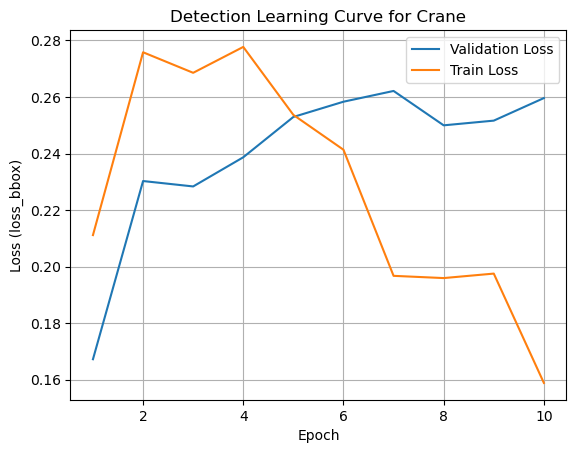

In [2]:
import json
import matplotlib.pyplot as plt

with open('./model/20240724_121658/vis_data/20240724_121658.json', 'r') as file:
    lines = file.readlines()

train_losses = []
val_losses = []
current_epoch = None
line_number = 0

for line in lines:

    entry = json.loads(line.strip())
    if 'epoch' in entry:
        train_losses.append((entry['epoch'], entry['iter'], entry['loss_bbox']))
        current_epoch = entry['epoch']
    elif 'loss' in entry:
        val_losses.append((current_epoch, entry['iter'], entry['loss_bbox']))

train_epochs, train_iters, train_loss_values = zip(*train_losses)
if val_losses:
    val_epochs, val_iters, val_loss_values = zip(*val_losses)
    plt.plot(val_epochs, val_loss_values, label='Validation Loss')

plt.plot(train_epochs, train_loss_values, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (loss_bbox)')
plt.title('Detection Learning Curve for Crane')
plt.legend()
plt.grid(True)
plt.show()

# ISSUE 1 Mention how the models are evaluated, create confusion  matrix 
### 5.4.2 Classification performance
Confusion matrix
Introduce about confusion matrix

Accuracy metics with confusion matixes
Brief the metrics calculated from confusion matixs, followed by demo code. Use scikit-learn for the demo code.

# 6 Improve model training
The models can be improved by performing combination of data augmentation, model architecture adjustments, hyperparameter tuning and some other techniques.

## 6.1 Data Augmentation:
By performing various augmentations to the training datasets, it can make the model robust and improve generalization. In mmdetection, ‘pipeline’ contains preprocessors of dataset such as augmentation. Some techniques are: Resize, RandomFlip, Normalize, Pad, RandomCrop, ColorTransform, etc.

In [3]:
# add the following parameter to cfg file to use mentioned data augmentation.
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='RandomCrop', crop_size=(800, 800)),
    dict(type='ColorTransform', prob=0.5, level=1),
    dict(type='Normalize', mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels']),
]

# The choice of selecting augmentation depends upon dataset characteristics, task requirements and domain knowledge.

## 6.2 Exploring Alternative Models and Datasets for Training
Pre-trained detectors from the COCO dataset serve as effective models for initializing on another dataset. Using models available in the Model Zoo can significantly enhance performance. To fine-tune a model for a new dataset, follow these steps:

**Inherit Base Configs:** mmdetection supports inheriting configurations from existing setups. Start by inheriting base configurations for model architecture (models/), dataset specifics (datasets/), and runtime settings (default_runtime.py) from mmdetection’s configs directory.

**Modify Configurations:** Adjust settings such as model backbone, ROI heads, and dataset paths to suit the characteristics of the new dataset. Modify parameters like num_classes in the ROI head to match the number of classes in the new dataset.

**Load Pre-trained Weights:** Initialize the model with weights pretrained on a large-scale dataset (e.g., COCO). This step initializes the model with beneficial learned features for object detection tasks.

**Fine-Tuning Process:** Fine-tune the initialized model using the new dataset. Optimize hyperparameters such as learning rate, optimizer type, and batch size to improve performance. Considerations include adjusting learning rates and epochs based on the dataset’s scale and complexity.

To use a pre-trained model, specify the path to the pretrained checkpoint in load_from. Ensure the model weights are downloaded before training to minimize download time during training.

In [4]:
# cfg.load_from = 'path_to_pretrained_checkpoint.pth'

**Model Architecture Adjustments:** To enhance the object detection capabilities, we can explore alternative models such as YOLOX. YOLOX is known for its efficiency and accuracy in real-time object detection tasks. Here’s how it can be configured and train a YOLOX model using your dataset.

# ISSUE 2
# TO BE REPLACED BY YOLOX IN FOLLOWING CELL

In [6]:
# Model can be adjusted with following component within cfg.model

model = dict(
    type='FPN',  # The overall architecture is a Feature Pyramid Network (FPN)
    backbone=dict(
        type='ResNet',  # The backbone of the FPN is a ResNet model
        depth=50,  # The depth of the ResNet backbone (ResNet-50)
        init_cfg=dict(
            type='Pretrained',  # Indicates that the backbone should be initialized with pretrained weights
            checkpoint='torchvision://resnet50'  # Specifies the source of the pretrained weights
        )
    ),
    # ...
)

## 6.3 Hyperparameter tuning:
 It involves adjusting the settings of a machine learning model to optimizer its performance. These settings, known as hyperparameters, are not learned from the training data but set prior to the training process. Effective tuning of hyperparameters such as learning rate, batch size, optimizer type, and the number of epochs can significantly impact the model’s accuracy and convergence speed. In mmdetection, hyperparameters are configured in the model’s configuration file and can be fine-tuned based on the specific dataset and task requirements to achieve better performance. We have a parameter scheduler, which dynamically adjusts learning rates and other hyperparameter during training to enhance model convergence and performance.

In [7]:
default_hooks = dict(
    param_scheduler=dict(
        type='ParamSchedulerHook',
        scheduler=[
            dict(
                begin=0,
                end=500,
                start_factor=0.001,
                type='LinearLR'
            ),
            dict(
                begin=0,
                by_epoch=True,
                end=12,
                gamma=0.1,
                milestones=[8, 11],
                type='MultiStepLR'
            )
        ]
    ),
    # ...
)